# Reading the ROOT files

In [1]:
exec(open("./do_imports.py").read())

2.3.0 /home/sophiafarrell/.local/lib/python3.7/site-packages/tensorflow/__init__.py


In [2]:
import seaborn as sns
from tqdm import tqdm


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [5]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',') + 1. 
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

In [6]:
npmt = pmtpos.shape[0]
pmtr = np.sqrt(pmtpos[:,0]**2 + pmtpos[:,1]**2).reshape(npmt, 1)
pmttheta = np.arctan2(pmtpos[:,1], pmtpos[:,0]).reshape(npmt, 1)
pmtz = pmtpos[:,2].reshape(npmt, 1)

pmtrad = np.hstack((pmtr, pmttheta, pmtz))

In [7]:
maxes = np.max(pmtrad, axis=0) 
mins = np.min(pmtrad, axis=0)
normed_pos = (pmtrad-mins)/(maxes-mins)

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [8]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

## Data Prep

In [91]:
def prep_net_data_simple(data_to_manipulate, 
                  keys = ['channel', 'pmtcharge', 'hittime', 'restime'],
                  maxlen=200):
    X = []
    y = np.array([])        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput))

        new[:,:,0] = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='pre', 
                                     dtype='int32')
        new[:,:,1] = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='pre', 
                                      dtype='float64')
        
        
        new[:,:,2] = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='pre', 
                                      dtype='float64')      
        new[:,:,3] = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='pre', 
                                      dtype='float64')
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))   
    if np.max(y)>1:
        lb = LabelBinarizer()
        y = lb.fit_transform(y)
    return X, y


In [75]:
def prep_net_data(data_to_manipulate, 
                  keys = ['channel', 'pmtcharge', 'hittime', 'restime'],
                  maxlen=200):
    X = []
    y = np.array([])        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn] #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz
        
        if 'restime' in keys:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))   
    if np.max(y)>1:
        lb = LabelBinarizer()
        y = lb.fit_transform(y)
    return X, y

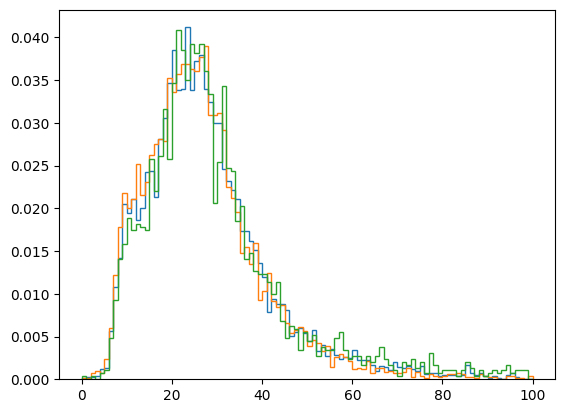

In [136]:
kw = dict(bins=np.linspace(0,100,101), histtype='step', density=True)
plt.hist(fastn[fastn.subid==0].n9, **kw)
plt.hist(fastn[fastn.subid==1].n9, **kw)

plt.hist(fastn[fastn.subid==3].n9, **kw)

plt.show()

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [9]:
selection = []

for d, data in enumerate([fastn, ibd]):
    subid0 = data.subid==0
    subid1 = data.subid>=1
    quicknext = data.dt_next_us < 500
    quickprev = data.dt_prev_us < 500
    longprev = data.dt_prev_us > 500
    
    if d==0:
        mask0 = ak.from_iter([all(t) for t in zip(quicknext, longprev)])
        mask1 = ak.from_iter([all(t) for t in zip(quickprev, subid1)])
    else: 
        mask0 = ak.from_iter([all(t) for t in zip(quicknext, subid0)])
        mask1 = ak.from_iter([all(t) for t in zip(quickprev, subid1)])
    signal0 = data[mask0]
    signal1 = data[mask1]
    
    selection.append(signal0)
    selection.append(signal1)

In [10]:
samples = min([len(i) for i in selection])
smth = [i[:samples] for i in selection]
data_to_manipulate = [ak.concatenate(smth[:2]), ak.concatenate(smth[2:])]
samples = min([len(i) for i in data_to_manipulate])


In [11]:
npmts = 2330
nbins = 150 
div_factor = 1500/nbins
y = np.array([]) 

newdata = np.zeros((2*samples, npmts, nbins))
print(newdata.shape)
for d, data in enumerate(data_to_manipulate):
    print('set %i of %i'%(d+1, len(data_to_manipulate)))
    new_bins = ak.values_astype((data.hittime-300)/div_factor, np.int32)
    y=np.append(y, d*np.ones(len(new_bins)))   
    for i in range(0, samples):
        newdata[(d+1)*i, data.channel[i], new_bins[i]]=data.pmtcharge[i] #data.restime[i]
        
X_train2, X_test2, y_train, y_test, = train_test_split(newdata, y,
                                                     test_size=0.25, random_state=43) 

(25660, 2330, 150)
set 1 of 2
set 2 of 2


KeyboardInterrupt: 

In [455]:
model = load_model('weights/fn_ibd_cnnmodel_semi.h5')

In [449]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2330, 128)         142848    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2330, 64)          49408     
_________________________________________________________________
reshape (Reshape)            (None, 466, 320, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 464, 318, 64)      640       
_________________________________________________________________
dropout (Dropout)            (None, 464, 318, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 232, 106, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 230, 104, 64)      3

In [456]:
model.evaluate(X_test2[:100], y_test[:100])

4/4 [==============================] - 3s 697ms/step - loss: 0.2886 - accuracy: 0.8400


[0.2886259853839874, 0.8399999737739563]

In [459]:
scores = model.predict(X_test2, verbose=1)
rnn_out_test = scores

201/201 [==============================] - 266s 1s/step


In [480]:
rnn_out_train = model.predict(X_train2, verbose=1)

602/602 [==============================] - 800s 1s/step


In [317]:
from tqdm.notebook import tqdm


In [471]:
layer_name = 'reshape'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(X_test2[:20])

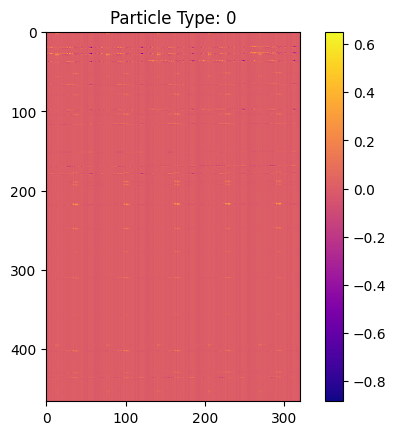

In [475]:
i=7

plt.imshow(intermediate_output[i], 
           cmap='plasma')
plt.title('Particle Type: %i'%(y_test[i]))
plt.colorbar()
plt.show()

In [476]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    y_test_2 = np.argmax(y_test, axis=1)
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

In [477]:
def draw_confmat(classes=3, 
                 y_test_2=y_test_2, 
                 y_pred_2=y_pred_2, 
                 scores=scores,):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=y_test_2, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RNN ROC: fastn/ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

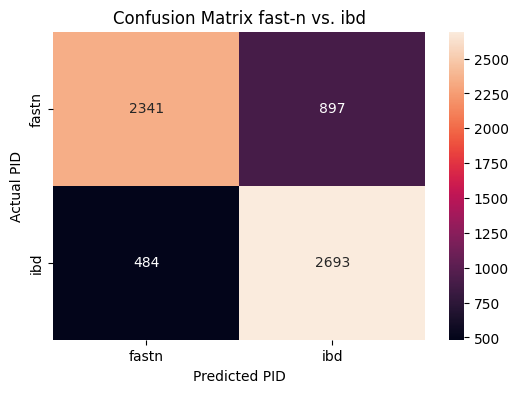

In [478]:
draw_confmat(classes=2)

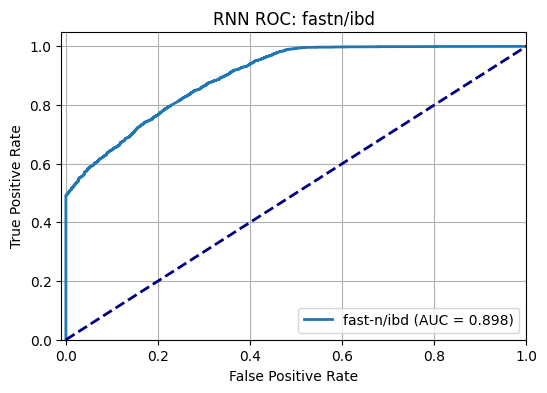

In [479]:
draw_roc(classes=2)

In [62]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def lines_from_origin(x, y, z, ax):
    for i in range(0, len(x)):
        x_val, y_val, z_val = x[i],y[i],z[i]
        ax.plot([vertex[0],x_val],[vertex[1],y_val],zs=[vertex[2],z_val], color="pink")

In [63]:
Xc,Yc,Zc = data_for_cylinder_along_z(0,0,569,569)

In [64]:
def get_azimuth(simple=True):
    rad=u**2+v**2
    if rad>0:
        rad = np.sqrt(rad)
        cos_phi=u/rad
        sin_phi=v/rad
        rot_xx=w*cos_phi
        rot_xy=w*sin_phi
        rot_xz=-1*np.sqrt((1+w)*(1-w))
        rot_yx = -1*sin_phi
        rot_yy = cos_phi
    else:
        rot_xy=rot_xz=rot_yx=0
        rot_yy=1
        rot_xx=1 if w>0 else -1

    dx = xyz[:,0] - vertex[0]
    dy = xyz[:,1] - vertex[1]
    dz = xyz[:,2] - vertex[2]
    rad = np.sqrt(dx**2+dy**2+dz**2)
    dx /= rad
    dy /= rad
    dz /= rad

    phi = np.arctan2(rot_yx*dx+rot_yy*dy,
                     rot_xx*dx+rot_xy*dy+rot_xz*dz)
    cosphi = np.cos(phi)
    mu_phi, sigma_phi = np.median(cosphi), np.std(cosphi)

    frac_in_std = np.sum(np.logical_and(cosphi<mu_phi+.3, cosphi>mu_phi-.3))/len(cosphi)
    if simple:
        return phi
    else:
        return mu_phi, sigma_phi, frac_in_std
#     print(frac_in_std)

In [87]:
data = eplus
delay= 100

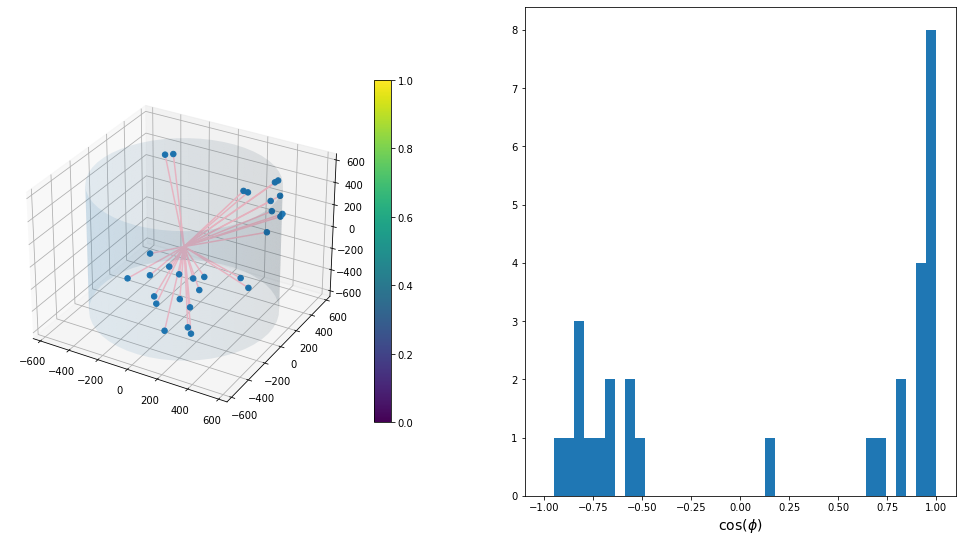

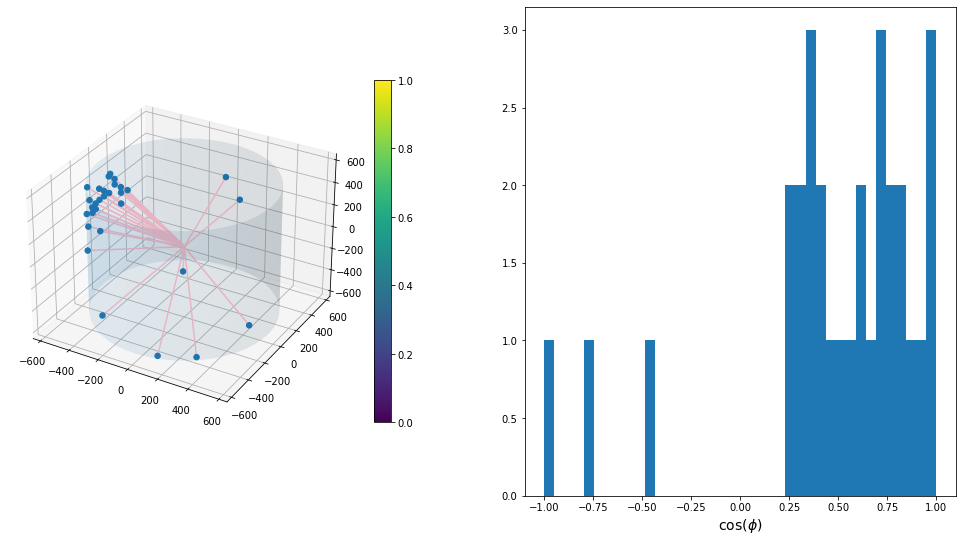

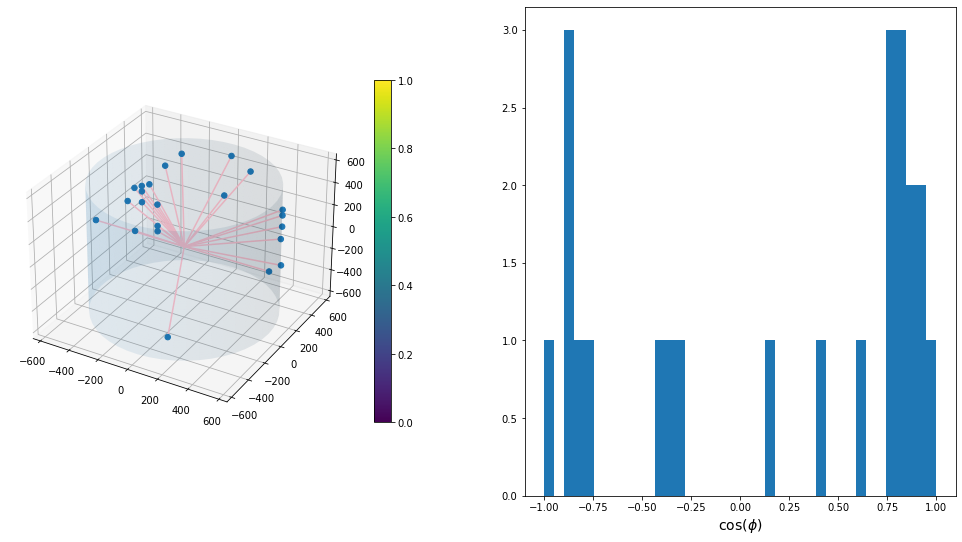

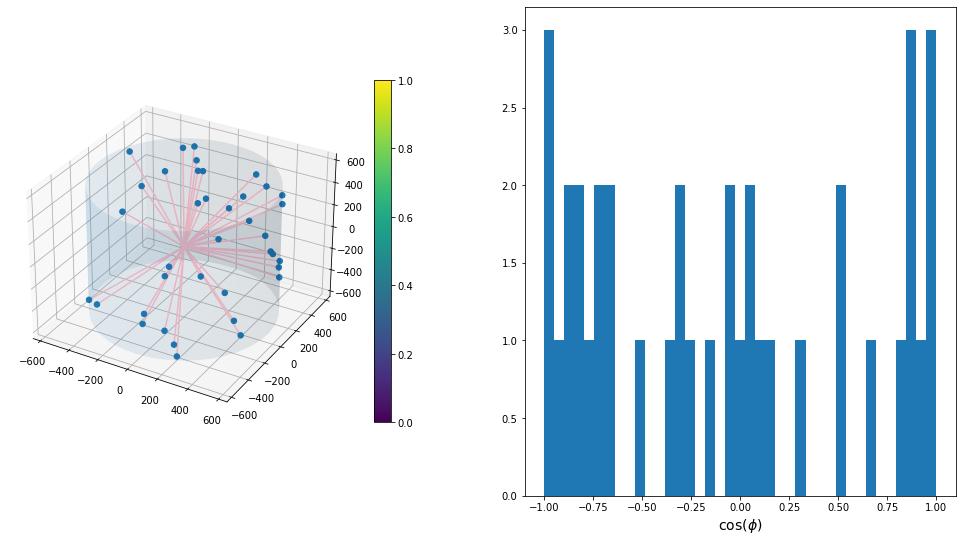

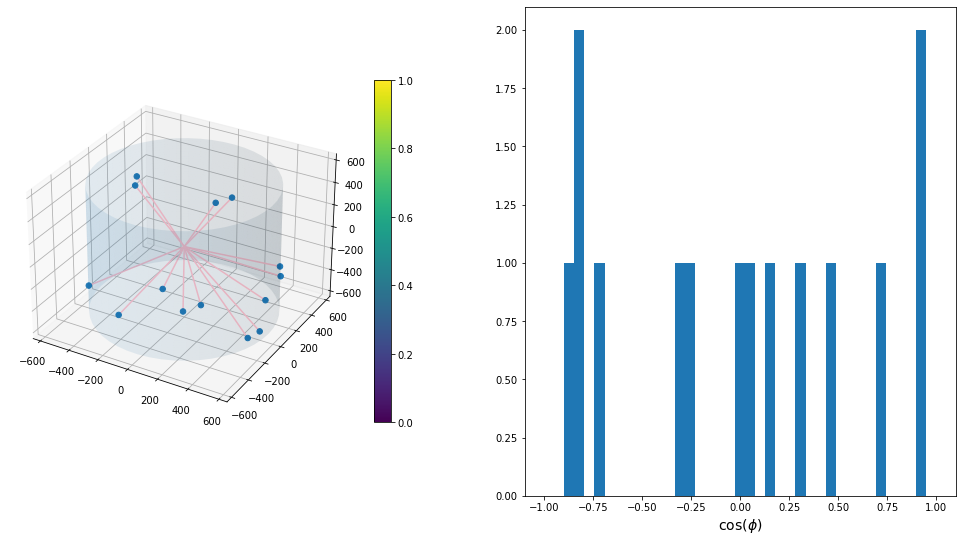

In [88]:
for i in range(2,7):
    ht = data['restime'][i]
    median = med(ht)
    ht = np.asarray(ht)
    prompt_mask = np.logical_and(ht>median-delay, ht<median+delay)
    
    xyz = pmtpos[data['channel'][i]][prompt_mask]
    u,v,w = data['mcu'][i], data['mcv'][i], data['mcw'][i]
    charge = data['pmtcharge'][i][prompt_mask]
    vertex = [0,0,0] # [data['mcx'][i]/10., data['mcy'][i]/10., data['mcz'][i]/10.]
#     db = DBSCAN(eps=2, min_samples=3).fit(xyz/100)
#     labels = db.labels_
    fig = plt.figure(figsize=(17,9))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(Xc, Yc, Zc, alpha=0.1)
    scat = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], alpha=1, 
#                       c=labels, 
#                       vmin=0., vmax=2., 
                      marker='o', s=30, )
    plt.colorbar(scat, shrink=0.7)
    lines_from_origin(xyz[:,0], xyz[:,1], xyz[:,2], ax)
#     ax.plot([vertex[0],u*100.-vertex[0]],[vertex[1],v*100.-vertex[1]],zs=[vertex[2],w*100.-vertex[2]], color="black")
    
    ax = fig.add_subplot(122)
    phis = get_azimuth()
    plt.hist(np.cos(phis), bins=np.linspace(-1, 1, 40))
    ax.set_xlabel('cos($\phi$)', fontsize=14)
#     ax.plot([vertex[1],v*570.-vertex[1]],[vertex[0],u*570.-vertex[0]],zs=[vertex[2],w*570.-vertex[2]], color="black")    
    
    plt.show()

## Evaluate RNN errors

In [481]:
preds = y_pred_2.reshape(len(y_pred_2))
error_inds = np.argwhere(y_test_2!=preds)
error_inds = error_inds.reshape(len(error_inds))

In [482]:
true_label = y_test_2[error_inds]

In [483]:
wrong_data = X_save.iloc[error_inds]
wrongibd = wrong_data[true_label==1]
wrongfn = wrong_data[true_label==0]

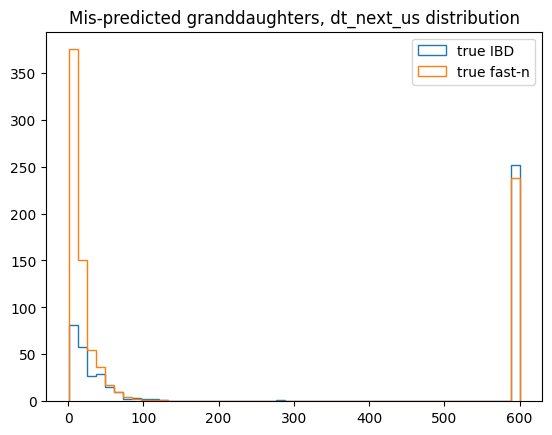

In [485]:
kw = dict(histtype='step')
key = 'dt_next_us'
bins= plt.hist(wrongibd[key], bins=50, label='true IBD', **kw)
plt.hist(wrongfn[key], bins=bins[1], label='true fast-n', **kw)
plt.title('Mis-predicted granddaughters, %s distribution'%(key))
plt.legend()
plt.show()

## Take RNN output and add to X1 (RF) data

In [12]:
dimensions = [
    'n9', 
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 
    'good_dir', 
    'good_pos',
#     'distpmt', 
    'closestPMT', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]

In [13]:
data_to_manipulate = [ak.concatenate(smth[:2]), ak.concatenate(smth[2:])]
samples = min([len(i) for i in data_to_manipulate])

x1 = data_to_manipulate[0]
x1 = ak.concatenate((x1, data_to_manipulate[1]))

X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X_train1, X_test1, y_train, y_test= train_test_split(X1, y, test_size=0.25, random_state=43) 

X_save = X_test1
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

Remaining variables selected for analysis: 32


In [495]:
def rnn_to_rf(classes=3, y_train=y_train, y_test=y_test):
    if classes==2: 
        yy_train, yy_test = y_train, y_test
    if classes>2:
        yy_train = np.argmax(y_train, axis=1)
        yy_test = np.argmax(y_test, axis=1)
    
    new_train = np.hstack((X_train1, rnn_out_train))
    new_test = np.hstack((X_test1, rnn_out_test))
    
    return new_train, new_test, yy_train, yy_test

In [496]:
classes=2
if classes==2: newdims = ['rnn_out']
elif classes==3: newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']

dims_add = dimensions.copy()
for i in newdims:
    dims_add.append(i)

In [497]:
new_train, new_test, yy_train, yy_test = rnn_to_rf(classes=2)

In [14]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
#     max_depth=10, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(X_train1,y_train)

RandomForestClassifier()

In [501]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
#     max_depth=10, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)

RandomForestClassifier()

In [18]:
y_train_pred = clf.predict(X_train1)
y_test_pred=clf.predict(X_test1)

# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 100.00%
Test Accuracy: 84.19%


In [15]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)

NameError: name 'new_train' is not defined

In [17]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

NameError: name 'yy_train' is not defined

In [19]:
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

NameError: name 'dims_add' is not defined

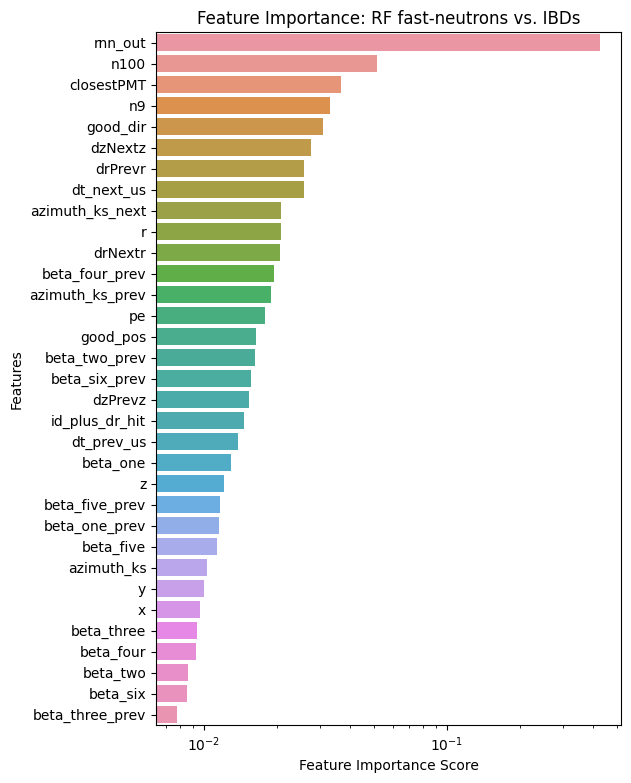

In [505]:
# Creating a bar plot
plt.figure(figsize=(6, 9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-neutrons vs. IBDs")
# plt.legend()
plt.show()

In [506]:
def draw_confmat(classes=3, 
                 y_test_2=y_test_2, 
                 y_pred_2=y_pred_2, 
                 scores=scores,
                **kwargs):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=y_test_2, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NN into RF ROC: fast-n vs. ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

In [507]:
scores = clf.predict_proba(new_test)

In [508]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    try: y_test_2 = np.argmax(y_test, axis=1)
    except: y_test_2=y_test
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

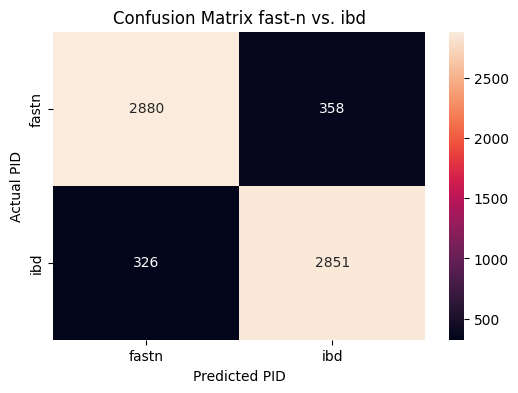

In [509]:
draw_confmat(classes=2, y_test_2=y_test_2, y_pred_2=y_pred_2)

In [510]:
ntot = np.sum(confmat)
nwrong = np.sum(confmat[1:,0]+confmat[0,1:])
1-nwrong/ntot

NameError: name 'confmat' is not defined

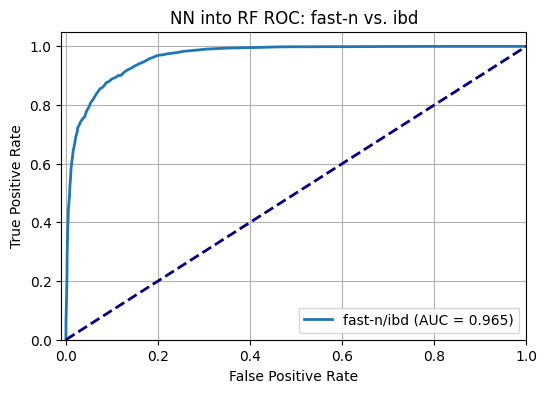

In [511]:
draw_roc(2, y_test_2, scores)

In [512]:
preds = y_pred_2.reshape(len(y_pred_2))
error_inds = np.argwhere(y_test_2!=preds)
error_inds = error_inds.reshape(len(error_inds))

In [513]:
true_label = y_test_2[error_inds]

In [514]:
wrong_data = X_save.iloc[error_inds]
wrongibd = wrong_data[true_label==1]
wrongfn = wrong_data[true_label==0]

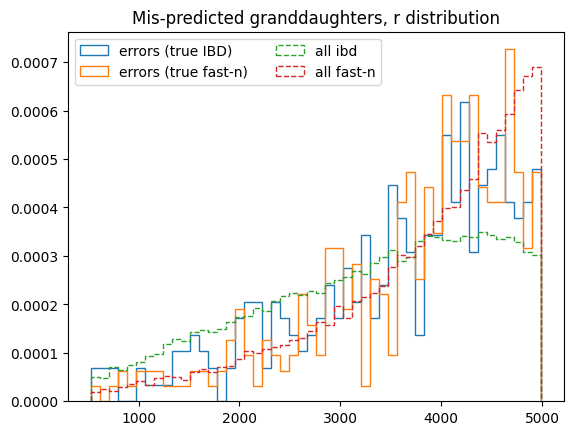

In [536]:
kw = dict(histtype='step', density=True)
key = 'r'
bins= plt.hist(wrongibd[key], bins=50, label='errors (true IBD)', **kw)
plt.hist(wrongfn[key], bins=bins[1], label='errors (true fast-n)', **kw)
plt.hist(ibd[key], bins=bins[1], label='all ibd', linestyle='--', **kw)
plt.hist(fastn[key], bins=bins[1], label='all fast-n', linestyle='--', **kw)

plt.title('Mis-predicted granddaughters, %s distribution'%(key))
plt.legend(loc='upper left', ncol=2)
plt.show()